# Collect and sort Tr, Val, Te results from IMPAC study

#### Conda environment:
#### /project/bioinformatics/DLLab/shared/CondaEnvironments/CooperAutism_TF_GPUv5/bin/python

In [160]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from ReformatTrainData import fReformatHistory
import glob

In [2]:
# Path to oriignal set of experiments
lsDataPaths=list()
for sType in ['Correlation', 'PartialCorrelation', 'Covariance', 'Precision', 'LSGC','Tangent']:
    lsDataPaths.append(f'/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/{sType}')
sNetwork='Dense'

In [3]:
import gc
def fFetch(sFile):
    """
    This function tries to fetch the specified file, but if it can't,
    it returns 0
    :param sFile: the file location (full path)
    :return: either the pickled file or 0 if unable to load with pickle
    """
    try:
        cObject=open(sFile,'rb')
        gc.disable()
        cFile=pkl.load(cObject)
        gc.enable()
        cObject.close()
        return cFile
    except:
        try:
            cObject=open(sFile,'rb')
            gc.disable()
            cFile=pkl.load(cObject, encoding='bytes')
            gc.enable()
            cObject.close()
            return cFile
        except:
            return 0

In [5]:
# concvert histories into training perf
lsTestResults=list()
for iConn, sConn in enumerate(['Correlation', 'PartialCorrelation', 'Covariance', 'Precision', 'LSGC','Tangent']):
    lsTestResults.append(glob.glob(f'{lsDataPaths[iConn]}/Dense/*ModelHistoryCrossVal*'))

lsTestResults

[['/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/Correlation/Dense/Dense_15connectivityharvard_oxford_cort_prob_2mmModelHistoryCrossVal1.p',
  '/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/Correlation/Dense/Dense_24connectivityharvard_oxford_cort_prob_2mmModelHistoryCrossVal1.p',
  '/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/Correlation/Dense/Dense_11combinedbasc197ModelHistoryCrossVal2.p',
  '/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/Correlation/Dense/Dense_24combinedpower_2011ModelHistoryCrossVal1.p',
  '/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/Correlation/Dense/Dense_01anatomyModelHistoryCrossVal3.p',
  '/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/Correlation/Dense/Dense_45connectivitybasc064ModelHistoryCrossVal2.p',
  '/project/bio

In [12]:
import gc
import keras.metrics
def auc_roc():
    pass

In [16]:
def fReformatHistory(sHistoryFile, sMetric='acc'):
    """
    Takes the keras history object and just saves the training score instead of the big object
    :param sHistoryFile: path to the history file
    :return: dumps a new pickled file of just the training score
    """
    import gc
    import keras.metrics
    keras.metrics.custom_metric=auc_roc
    keras.metrics.auc_roc=auc_roc
    # disable gc for a speedup
    cFile=open(sHistoryFile,'rb')
    gc.disable()
    cModelHist=pkl.load(cFile)
    gc.enable()
    cFile.close()

    # dump training perf
    flTrainPerf=cModelHist.history[sMetric][np.argmax(cModelHist.history[f'val_{sMetric}'])]
    pkl.dump(flTrainPerf, open(sHistoryFile.replace('ModelHistory', f'Train{sMetric.upper()}Score'),'wb'))

In [17]:
import seaborn as sns

In [18]:
def fPlotHistory(sDataPath, sNetwork, iModel, sModality, sAtlas):
    """
    Takes the keras history object and just saves the training score instead of the big object
    :param sHistoryFile: path to the history file
    :return: dumps a new pickled file of just the training score
    """
    #allow history to be imported with custom metric
    import gc
    import keras.metrics
    from IMPAC_DenseNetwork import auc_roc
    keras.metrics.custom_metric=auc_roc
    keras.metrics.auc_roc=auc_roc
    
    bFirstTime=True
    for iCV in range(3):
        #Load history
        sHistoryFile=os.path.join(sDataPath, sNetwork, f'{sNetwork}_{iModel}{sModality}{sAtlas}ModelHistoryCrossVal{iCV+1}.p')
        # disable gc for a speedup
        cFile=open(sHistoryFile,'rb')
        gc.disable()
        cModelHist=pkl.load(cFile)
        gc.enable()
        cFile.close()
        
        # fetch each metric and store it
        lsMetrics=['loss', 'acc', 'auc_roc']
        for sMetric in lsMetrics:
            lsTrainPerf=cModelHist.history[sMetric]
            lsValPerf=cModelHist.history[f'val_{sMetric}']
            lsMetric=list(map(lambda e: (sMetric), lsValPerf))
            lsEpoch=list(range(len(lsValPerf)))
            lsTr=list(map(lambda e: ('Train'), lsValPerf))
            lsVal=list(map(lambda e: ('Validation'), lsValPerf))
            zlsTr=list(zip(lsEpoch, lsTrainPerf, lsMetric, lsTr))
            zlsVal=list(zip(lsEpoch, lsValPerf, lsMetric, lsVal))
            zls=zlsTr+zlsVal
            # put in seaborn-friendly dataframe
            pdCV=pd.DataFrame(zls, columns=['Epoch', 'Performance', 'Metric', 'Tr/Val'])
            if bFirstTime:
                pdAll=pdCV
                bFirstTime=False
            else:
                pdAll=pdAll.append(pdCV, ignore_index=True)
    # Plot metrics
    for sMetric in lsMetrics:
        ax=sns.lineplot(x='Epoch', y='Performance', hue='Tr/Val', data=pdAll.loc[pdAll['Metric'] == sMetric])
        ax.set_ylabel(f'{sMetric.replace("_", " ").title()}')
        ax.set_title(f'Training Performance ({sMetric.replace("_", " ").title()}) of Model {iModel}')
        if not os.path.isdir(os.path.join(sDataPath,'Images')):
            os.mkdir(os.path.join(sDataPath,'Images'))
        plt.savefig(os.path.join(sDataPath, 'Images', f'{sNetwork}{iModel}_Training{sMetric.title()}.png'))
        plt.close()

In [19]:
Parallel(n_jobs=32)(delayed(fReformatHistory)(sFile, 'auc_roc') for sFile in lsTestResults)

TypeError: expected str, bytes or os.PathLike object, not list

In [20]:
def fLoadTrTeVal(sDataPath, sNetwork, sModality, iModel, sAtlas):
    # set sAtlas to '' if anatomy

    flNetworkAvg=0
    flNetworkTrainAvg=0

    # fetch the average performance across 3 cross-validations (tr and val)
    for iCV in range(3):
        iCV=iCV + 1
        sCV=str(iCV)
        #flNetworkTrainCV=fFetch(os.path.join(sDataPath, sNetwork, f'{sNetwork}_{iModel}{sModality}{sAtlas}TrainAUC_ROCScoreCrossVal{sCV}.p'))
        flNetworkCV=fFetch(os.path.join(sDataPath, sNetwork, f'{sNetwork}_{iModel}{sModality}{sAtlas}ROCScoreCrossVal{sCV}.p'))

        #flNetworkTrainAvg = flNetworkTrainAvg + flNetworkTrainCV
        flNetworkAvg = flNetworkAvg + flNetworkCV

    # Fetch the results of a specified model, modality, and atlas
    #flNetworkTrainAvg = (flNetworkTrainAvg / (3.0))
    flNetworkAvg = (flNetworkAvg / (3.0))
    flNetworkTest = fFetch(os.path.join(sDataPath, sNetwork, f'{sNetwork}_{iModel}{sModality}{sAtlas}ROCScoreTest.p'))

    return flNetworkAvg, flNetworkTest #flNetworkTrainAvg, 

In [21]:
# Generate lists to loop through
lsAtlases = ['basc064', 'basc122', 'basc197', 'craddock_scorr_mean', 'harvard_oxford_cort_prob_2mm', 'msdl', 'power_2011']
lsModalities = ['anatomy', 'connectivity', 'combined']
lsNetworks = ['Dense']#, 'LSTM']

#generate pandas index and col
lsIndex=[]
for sModality in lsModalities:
    if sModality=='anatomy':
        lsAtlases2=['']
    else:
        lsAtlases2=lsAtlases
    for sAtlas in lsAtlases2:
        lsIndex.append(f'{sModality}{sAtlas}')
lsColumns=[
    #'Avg. ROCAUC Train',
    'Avg. ROCAUC Validation',
    #'Generalization Error',
    'ROCAUC Test'
]

In [47]:
lsAtlases2

['basc064',
 'basc122',
 'basc197',
 'craddock_scorr_mean',
 'harvard_oxford_cort_prob_2mm',
 'msdl',
 'power_2011']

In [50]:
#dResults={}
iModels=50
pdResults=pd.DataFrame(index=range(iModels), columns=lsColumns)
dResults={}
for sDataPath in lsDataPaths:
    dResults.update({sDataPath.split('/')[-1]: {}})
    for sNetworkName in lsNetworks:
        #dResults[sNetworkName]={}
        for iModel in range(iModels):
            #dResults[sNetworkName][iModel]=pd.DataFrame(index=lsIndex, columns=lsColumns)
            for sModality in lsModalities:
                if sModality=='anatomy':
                    lsAtlases2=['']
                else:
                    lsAtlases2=lsAtlases
                for sAtlas in lsAtlases2:
                    flVal, flTe=fLoadTrTeVal(sDataPath, sNetworkName, sModality, iModel, sAtlas)
                    #pdResults.loc[iModel, lsColumns[0]]=flTr
                    pdResults.loc[iModel, lsColumns[0]]=flVal
                    pdResults.loc[iModel,  lsColumns[1]]=flTe
                    dResults[sDataPath.split('/')[-1]].update({f'{sModality}{sAtlas}':pdResults.loc[pdResults['Avg. ROCAUC Validation']==pdResults['Avg. ROCAUC Validation'].max()]})
                        #pdResults.loc[iModel, lsColumns[3]]=flTe
    #                     dResults[sNetworkName][iModel].loc[f'{sModality}{sAtlas}', lsColumns[0]]=flTr
    #                     dResults[sNetworkName][iModel].loc[f'{sModality}{sAtlas}',  lsColumns[1]]=flVal
    #                     dResults[sNetworkName][iModel].loc[f'{sModality}{sAtlas}', lsColumns[2]]=flTe


In [63]:
dResults['Tangent']['connectivitybasc122']['Metric']=['Tangent']
dResults['Tangent']['connectivitybasc122']['Features']=['connectivitybasc122']
dResults['Tangent']['connectivitybasc122']

/project/bioinformatics/DLLab/shared/CondaEnvironments/CooperAutismTF_GPU_v5/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/project/bioinformatics/DLLab/shared/CondaEnvironments/CooperAutismTF_GPU_v5/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Avg. ROCAUC Validation,ROCAUC Test,Metric,Features
17,0.558014,0.554113,Tangent,connectivitybasc122


In [53]:
pdAllResultsCombined=pd.DataFrame(columns=[*lsColumns, 'Metric', 'Features'])
for sKey in dResults.keys():
    for sKey2 in dResults[sKey].keys()
        pdAllResultsCombined['Avg. ROCAUC Validation'].append(dResults[sKey][sKey2]['Avg. ROCAUC Validation'])
        pdAllResultsCombined['ROCAUC Test'].append(dResults[sKey][sKey2]['ROCAUC Test'])
        pdAllResultsCombined['Metric']=
        pdAllResultsCombined['Features']      

,Avg. ROCAUC Validation,ROCAUC Test


In [27]:
#dNNResults=dResults
for sKey in dResults.keys():
    for sKey2 in dResults[sKey].keys():
        dResults[sKey][sKey2]

{'Correlation': {'anatomy':    Avg. ROCAUC Validation ROCAUC Test
  0                0.477397    0.569745
  1                     0.5         0.5
  2                 0.51143    0.567581
  3                     0.5         0.5
  4                0.527523         0.5
  5                0.555114    0.561688
  6                0.501302     0.57672
  7                0.476849    0.578884
  8                0.513773    0.558442
  9                0.494334    0.555435
  10               0.508748    0.571068
  11               0.492936    0.565657
  12               0.485151    0.563372
  13               0.461718    0.471982
  14               0.505697    0.518879
  15               0.508018    0.573473
  16               0.504361    0.555796
  17               0.558014    0.554113
  18               0.513852    0.549663
  19               0.510533         0.5
  20               0.484487    0.592352
  21               0.483075    0.595479
  22                0.48424    0.580207
  23          

In [52]:
import tensorflow as tf

In [54]:
print(tf.__version__)

1.10.0


In [31]:
# delete obviously erroneous rows:
pdResults=pdResults.loc[pdResults['Avg. ROCAUC Validation'] > 0.60]
pdResults=pdResults.loc[pdResults['Avg. ROCAUC Train'] > 0]
pdResults=pdResults.sort_values(by=['Generalization Error'], ascending=True)
pdResults.head()

,Avg. ROCAUC Train,Avg. ROCAUC Validation,Generalization Error
4,0.615075,0.699214,-0.084140
0,0.895996,0.698005,0.197992
17,0.906901,0.703602,0.203299
10,0.87339,0.658483,0.214907
2,0.867473,0.631204,0.236269


In [32]:
for iModel in [4,0,17,10]:
    fPlotHistory(sDataPath, sNetwork, iModel, sModality, sAtlas)

In [37]:
# results in form of dict[Dense/LSTM][ModelNum] pd Dataframe, index=anatomy,
#connectivity{atlas}, combined{atlas}, col=Avg. ROCAUC Train, Avg. ROC AUC Val, ROC AUC Test
dNNResults

{'Dense': {0:                 Avg. ROCAUC Train Avg. ROCAUC Validation ROCAUC Test
  combinedbasc122                 0               0.585165    0.740139,
  1:                 Avg. ROCAUC Train Avg. ROCAUC Validation ROCAUC Test
  combinedbasc122                 0               0.540097    0.578163,
  2:                 Avg. ROCAUC Train Avg. ROCAUC Validation ROCAUC Test
  combinedbasc122                 0               0.551575    0.627465,
  3:                 Avg. ROCAUC Train Avg. ROCAUC Validation ROCAUC Test
  combinedbasc122                 0               0.686398         0.5,
  4:                 Avg. ROCAUC Train Avg. ROCAUC Validation ROCAUC Test
  combinedbasc122                 0               0.596058    0.775493,
  5:                 Avg. ROCAUC Train Avg. ROCAUC Validation ROCAUC Test
  combinedbasc122                 0               0.535272    0.559043,
  6:                 Avg. ROCAUC Train Avg. ROCAUC Validation ROCAUC Test
  combinedbasc122                 0      

### Next is fetching the ML results 

In [90]:
lsMLModels=[
    'AdaBoost',
    'ExRanTrees',
    'GaussSVM',
    'LinLasso',
    'LinRidge',
    'LinSVM',
    #'NaiveBayes', #Naive bayes didn't have a hyperparameter optimization
    'RandFor',
    'XGBoost'
]

In [69]:
def fGetShallowTrVal(sModality, sAtlas, sMLModel):
    """
    retreives training and validation data from the shallow ml models
    """
    #set sAtlas to 'only' for anatomical data
    sRoot="/project/bioinformatics/DLLab/Cooper/Results/IMPAC/ShallowLearningResults/3_fold_cv_50_random_hyperparameter_initializations_random_search0924"
    sFile=os.path.join(sRoot, f'{sModality}_{sAtlas}', f'{sMLModel}.p')
    
    # load more quickly
    cObject=open(sFile,'rb')
    gc.disable()
    cFile=pkl.load(cObject)
    gc.enable()
    cObject.close()
    
    # get specific Tr, Val results
    lsTr=cFile.cv_results_['mean_train_score']
    lsVal=cFile.cv_results_['mean_test_score']
    lsModels=cFile.cv_results_['rank_test_score']
    
    pdResults=pd.DataFrame(index=lsModels, columns=lsColumns[0:2])
    for i in range(len(lsModels)):
        pdResults.loc[lsModels[i],lsColumns[0]]=lsTr[i]
        pdResults.loc[lsModels[i],lsColumns[1]]=lsVal[i]
    
    return pdResults.sort_values(by=[lsColumns[1]], ascending=False)

In [110]:
# Loop through and fetch training testing, validation for the different shallow models
dMLResults={}
for sModality in lsModalities:
    if sModality=='anatomy':
        sModality='anatomical'
        lsAtlases2=['only']
    else:
        lsAtlases2=lsAtlases
    dMLResults[sModality]={}
    for sAtlas in lsAtlases2:
        dMLResults[sModality][sAtlas]={}
        for sMLModel in lsMLModels:
            dMLResults[sModality][sAtlas][sMLModel]=fGetShallowTrTeVal(sModality, sAtlas, sMLModel)

In [104]:
#Results of form dict[modality (anatomical, connectivity, or combined)]
#[Atlas ("only" for anatomical data)][ML model]= pd Dataframe, row=model num, col=Tr, Val ROCAUC
dMLResults['anatomical']['only'].keys()

dict_keys(['AdaBoost', 'ExRanTrees', 'GaussSVM', 'LinLasso', 'LinRidge', 'LinSVM', 'RandFor', 'XGBoost'])

In [152]:
lsMLModels.append('Dense')
lsMLModels.append('LSTM')
lsModels=lsMLModels
pdDense=pd.DataFrame(index=range(50), columns=lsColumns[0:2])
pdLSTM=pd.DataFrame(index=range(50), columns=lsColumns[0:2])
dDFs={}
dDFs.update({'Dense': pdDense, 'LSTM': pdLSTM})

In [86]:
lsModels

['AdaBoost',
 'ExRanTrees',
 'GaussSVM',
 'LinLasso',
 'LinRidge',
 'LinSVM',
 'RandFor',
 'XGBoost',
 'Dense',
 'LSTM']

In [130]:
lsModalities

['anatomy', 'connectivity', 'combined']

In [143]:
def fUnifyResults(dNNResults, dMLResults):
    """
    Combine the NN and shalow ML results in a single format
    """
    dUnifiedResults={}
    for sModality in lsModalities:
        if sModality=='anatomy':
            sModality2='anatomical'
            lsAtlases2=['only']
        else:
            sModality2=sModality
            lsAtlases2=lsAtlases
        dUnifiedResults[sModality2]={}
        for sAtlas in lsAtlases2:
            dUnifiedResults[sModality2][sAtlas]={}
            for sMLModel in lsModels:
                if sMLModel=='Dense' or sMLModel=='LSTM':
                    for iModel in range(50):
                        if sAtlas=='only':
                            sAtlas2=''
                        else:
                            sAtlas2=sAtlas
                        dDFs[sMLModel].loc[iModel, lsColumns[0]]=dNNResults[sMLModel][iModel].loc[f'{sModality}{sAtlas2}', lsColumns[0]]
                        dDFs[sMLModel].loc[iModel, lsColumns[1]]=dNNResults[sMLModel][iModel].loc[f'{sModality}{sAtlas2}', lsColumns[1]]
                    dDFs[sMLModel]=dDFs[sMLModel].fillna(0)
                    dUnifiedResults[sModality2][sAtlas][sMLModel]=dDFs[sMLModel].sort_values(by=[lsColumns[1]], ascending=False)
                else:
                    dUnifiedResults[sModality2][sAtlas][sMLModel]=dMLResults[sModality2][sAtlas][sMLModel]
    return dUnifiedResults

In [144]:
dUnifiedResults=fUnifyResults(dNNResults, dMLResults)

In [158]:
# Create rows and col for plotting
lsIndex=['anatomy']
lsColumns=lsMLModels
for sType in ['connectivity', 'combined']:
    for sAtlas in lsAtlases:
        lsIndex.append(f'{sType}_{sAtlas}')
lsIndex, lsColumns

(['anatomy',
  'connectivity_basc064',
  'connectivity_basc122',
  'connectivity_basc197',
  'connectivity_craddock_scorr_mean',
  'connectivity_harvard_oxford_cort_prob_2mm',
  'connectivity_msdl',
  'connectivity_power_2011',
  'combined_basc064',
  'combined_basc122',
  'combined_basc197',
  'combined_craddock_scorr_mean',
  'combined_harvard_oxford_cort_prob_2mm',
  'combined_msdl',
  'combined_power_2011'],
 ['AdaBoost',
  'ExRanTrees',
  'GaussSVM',
  'LinLasso',
  'LinRidge',
  'LinSVM',
  'RandFor',
  'XGBoost',
  'Dense',
  'LSTM'])

In [185]:
#reformat data for plotting
def fReformatForPlotting(dUnifiedResults):
    dModelResultsByPerf={}
    for i in range(50):
        dModelResultsByPerf[i]=pd.DataFrame(index=range(300), columns=['Value', 'Tr/Te', 'Input', 'MLModel'])
        iloc=0
        for sMLModel in lsMLModels:
            dModelResultsByPerf[i].loc[iloc,'Value']=dUnifiedResults['anatomical']['only'][sMLModel].iloc[i].values[0]
            dModelResultsByPerf[i].loc[iloc,'Tr/Te']='Tr'
            dModelResultsByPerf[i].loc[iloc,'Input']='anatomy'
            dModelResultsByPerf[i].loc[iloc,'MLModel']=sMLModel
            iloc+=1
            dModelResultsByPerf[i].loc[iloc,'Value']=dUnifiedResults['anatomical']['only'][sMLModel].iloc[i].values[1]
            dModelResultsByPerf[i].loc[iloc,'Tr/Te']='Te'
            dModelResultsByPerf[i].loc[iloc,'Input']='anatomy'
            dModelResultsByPerf[i].loc[iloc,'MLModel']=sMLModel
            iloc+=1            
        for sMLModel in lsMLModels:
            for sModality in ['connectivity', 'combined']:
                for sAtlas in lsAtlases:
                    dModelResultsByPerf[i].loc[iloc,'Value']=dUnifiedResults[sModality][sAtlas][sMLModel].iloc[i].values[0]
                    dModelResultsByPerf[i].loc[iloc,'Tr/Te']='Tr'
                    dModelResultsByPerf[i].loc[iloc,'Input']=f'{sModality}_{sAtlas}'
                    dModelResultsByPerf[i].loc[iloc,'MLModel']=sMLModel
                    iloc+=1
                    dModelResultsByPerf[i].loc[iloc,'Value']=dUnifiedResults[sModality][sAtlas][sMLModel].iloc[i].values[1]
                    dModelResultsByPerf[i].loc[iloc,'Tr/Te']='Te'
                    dModelResultsByPerf[i].loc[iloc,'Input']=f'{sModality}_{sAtlas}'
                    dModelResultsByPerf[i].loc[iloc,'MLModel']=sMLModel
                    iloc+=1  
    return dModelResultsByPerf                

In [186]:
dModelResultsByPerf=fReformatForPlotting(dUnifiedResults)

## Now, we do some plotting

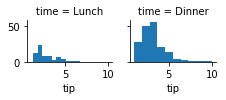

In [183]:
import seaborn as sns
tips=sns.load_dataset("tips")
g=sns.FacetGrid(tips, col="time", col_wrap=5, height=1.5)
g.map(plt.hist, "tip")

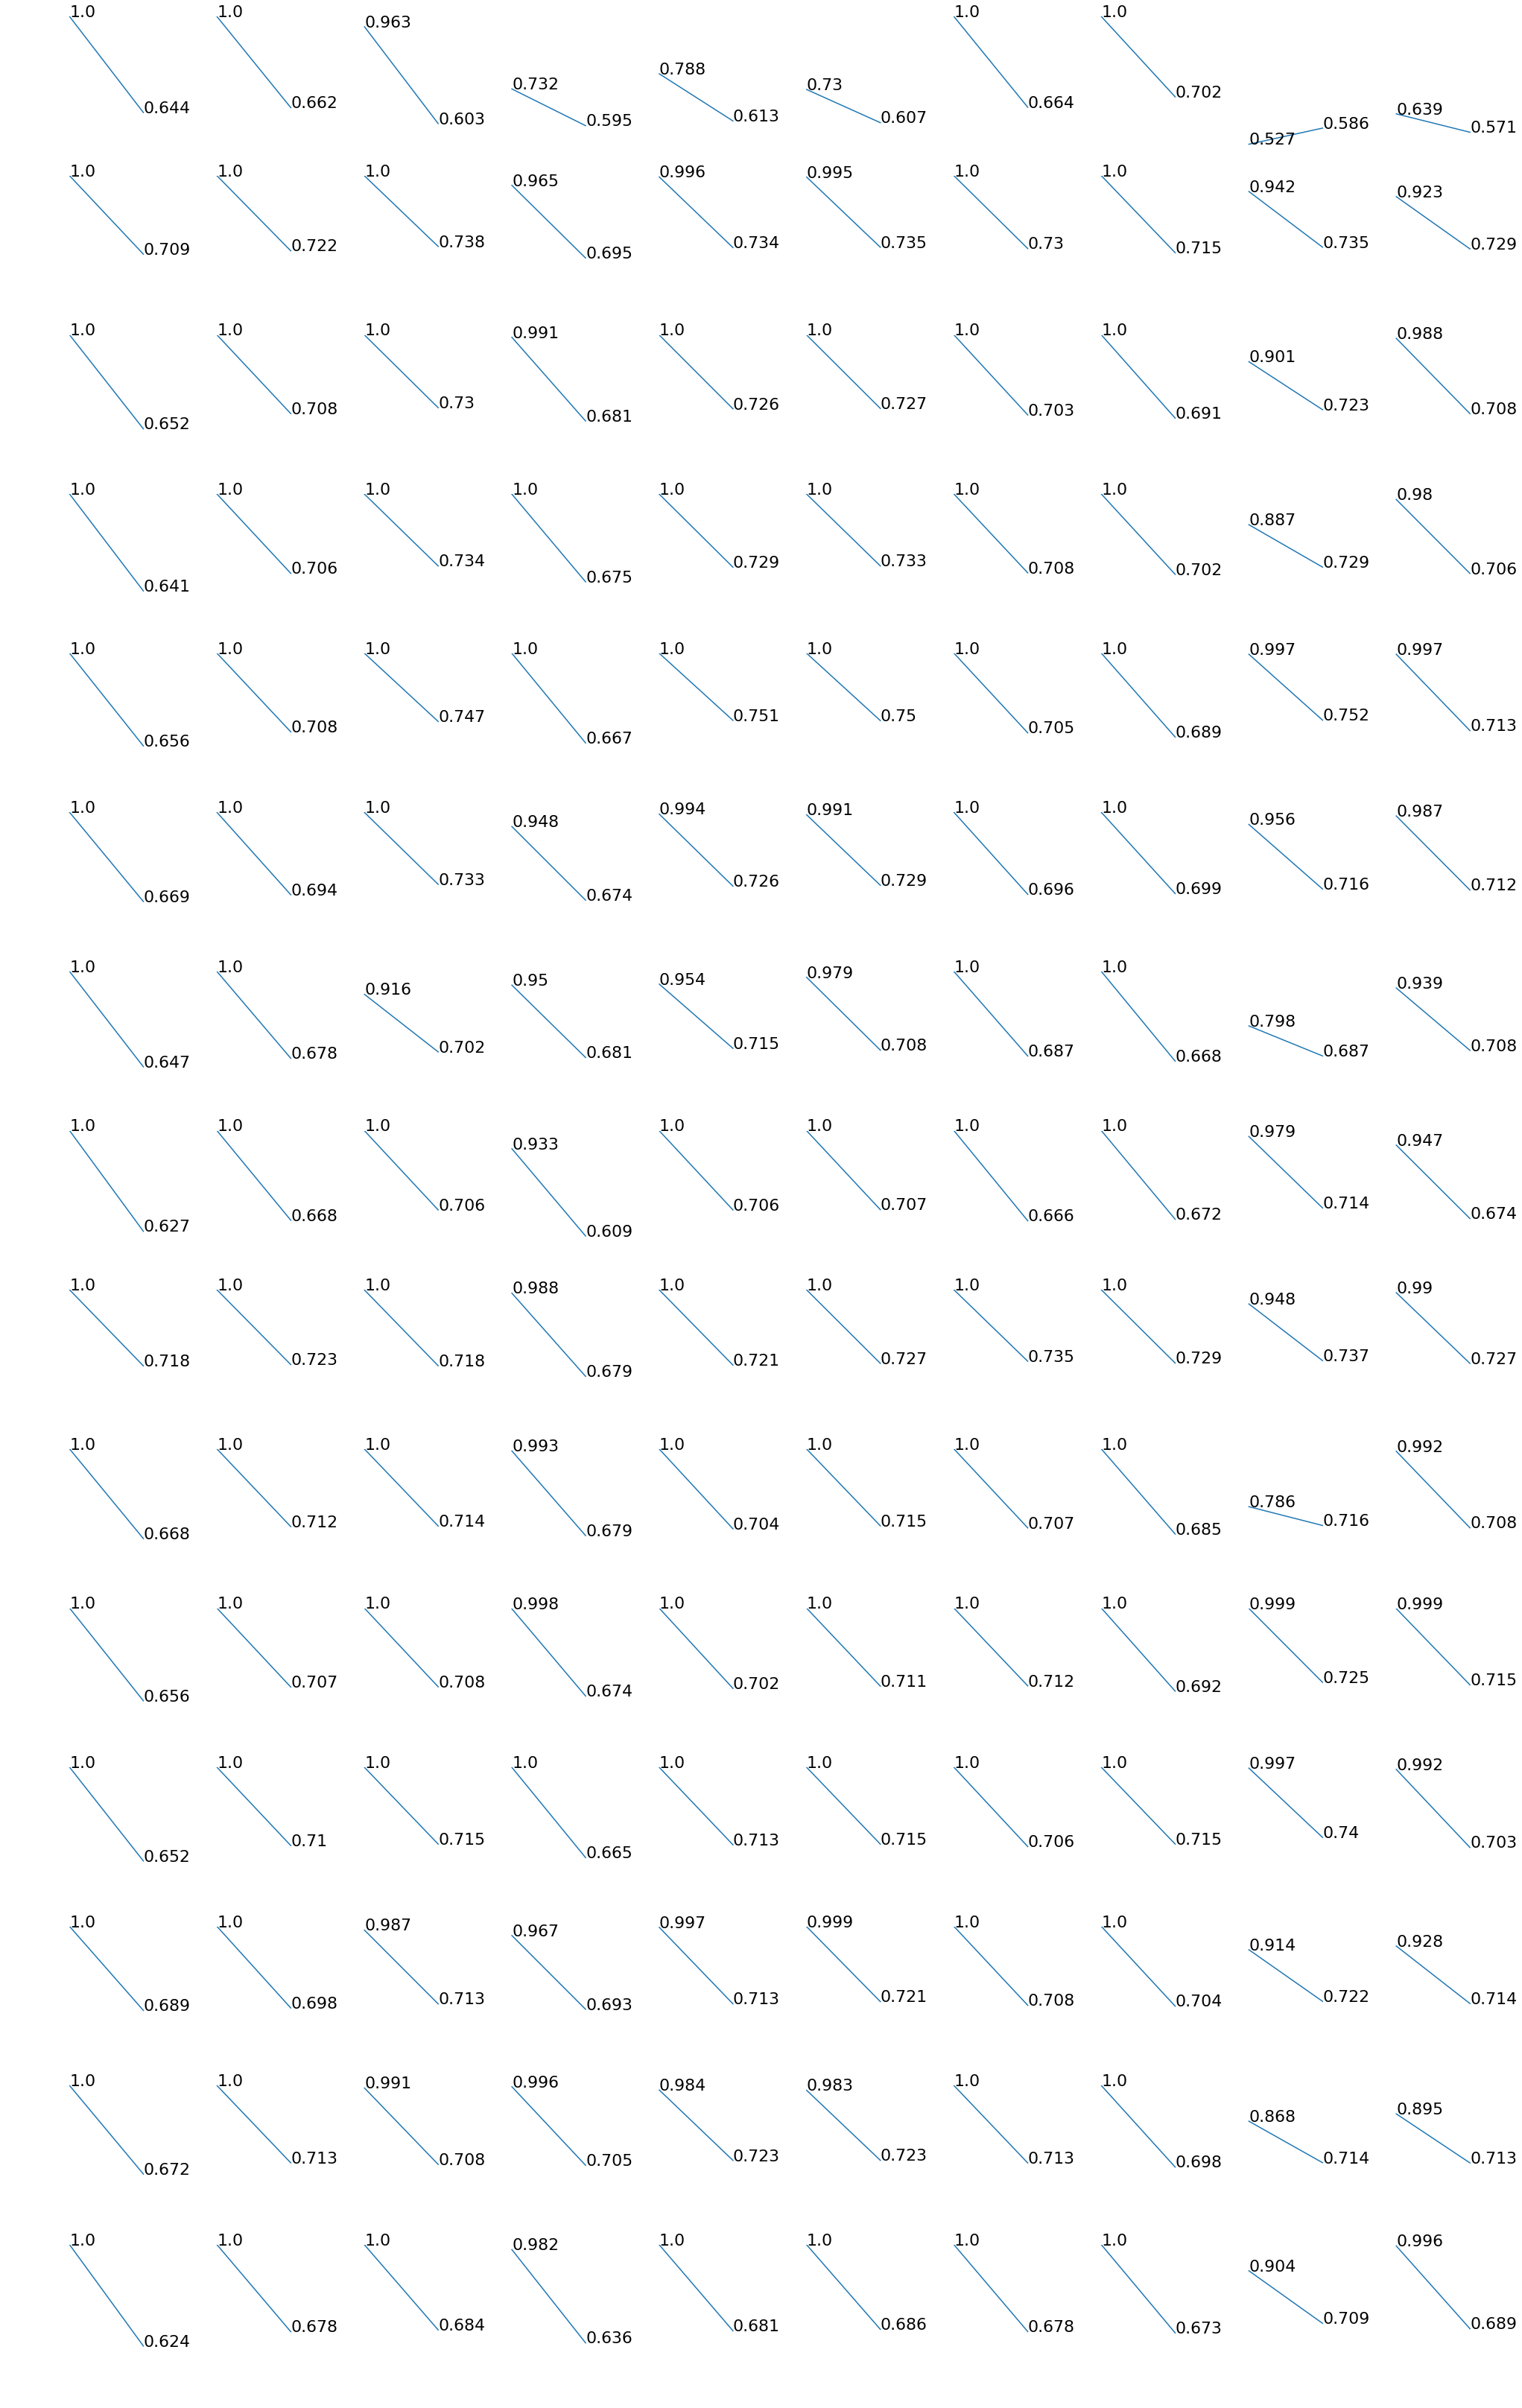

In [227]:
def fPlot(sTrTe, flVal, **kwargs):
    plt.xlim(-0.5,1.5)
    plt.plot(sTrTe, flVal, **kwargs)

    plt.annotate( f'{round(flVal.values[0],3)}',xy=('Tr', flVal.values[0]), fontsize=22)
    plt.annotate( f'{round(flVal.values[1],3)}',xy=(1, flVal.values[1]), fontsize=22)
    plt.axis('off')
    ax=plt.gca()
    ax.set_facecolor('r')
    plt.ylim([0.5,1])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    
def fFacetPlot(iThBest):
    g=sns.FacetGrid(dModelResultsByPerf[iThBest], col='MLModel', row='Input', gridspec_kws={"wspace":0})

    g.map(fPlot, 'Tr/Te', 'Value')
    
    g.set_titles('')

fFacetPlot(0)

In [221]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The foll

In [ ]:
def fGridPlot():
    #save stuff
    return sImagePath

In [ ]:
sImagePath=fGridPlot()

cImage=mpl.image.imread(sImagePath)

In [ ]:
cHeatMap=sns.heatmap(
heatmap_data,
cmap=matplotlib.cm.winter,
alpha=0.3,
annot=False,
zorder=2
)

cHeatMap.imshow(
    cImage,
    aspect=cHeatMap.get_aspect(),
    extent=cHeatMap.get_xlim()+cHeatMap.get_ylim(),
    zorder=1
)

plt.show()